# Genre analysis

This notebook will analyze the evolution of genres in movies over the years and over the countries.

In [2]:
# Modules to import
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from dash import *

In [7]:
# Paths to add
paths = ['../data','../scripts','../utils']
for path in paths:
    sys.path.append(path)
    
# Data loader
from dataLoader import loadDataframe

# Load data
path_to_directory = '../../data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)

c:\Users\arnau\OneDrive\Documents\Scolarité EPFL\ADA\ada-2024-project-teamcsx24\src\data\dataLoader.py:10: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



### Creation of dataframe (number of movies per genre per year per region or country)

Modification of country names to match with geopandas name

In [8]:
df_movies.head(2)

,wiki_id,freebase_id,original_title,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],[/m/02h40lc],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]"


In [9]:
from generalUtils import transformCountryNameGpd
df_movies['countries'] = df_movies['countries_freebase_id'].apply(transformCountryNameGpd)

Preparation of the dataset for the analysis (explode genres and countries)

In [10]:
df_genres_countries_exploded = df_movies.explode('genres').explode('countries')
df_genres_countries_exploded.head(3)

,wiki_id,freebase_id,original_title,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Thriller,[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Science Fiction,[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Horror,[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."


In [11]:
# Check for missing values
df_genres_countries_exploded.isna().sum()

wiki_id                       0
freebase_id                   0
original_title                0
release_date              12530
revenue                  240221
runtime                   41850
languages                     0
countries                 13759
genres                     2361
countries_freebase_id         0
languages_freebase_id         0
genres_freebase_id            0
dtype: int64

In [12]:
# Print number of movies
nb_movies = df_genres_countries_exploded['wiki_id'].nunique()
print(f'Total number of movies: {nb_movies}')

df_genres_countries_exploded.dropna(subset=['countries','release_date','genres'], inplace=True)

nb_movies_after_dropna = df_genres_countries_exploded['wiki_id'].nunique()
print(f'Total number of movies with countries, release date and genres: {nb_movies_after_dropna}')

print(f'Pourcentage of dropped movies: {100*(1-nb_movies_after_dropna/nb_movies):.2f}%')

Total number of movies: 81741
Total number of movies with countries, release date and genres: 68144
Pourcentage of dropped movies: 16.63%


Only 84% of the movies have genre, country and release date information. It represents 68144 movies, which seems to be enough for the analysis.

In [13]:
from generalUtils import attachWorldRegion
df_genres_countries_exploded['region'] = df_genres_countries_exploded['countries'].apply(attachWorldRegion)

In [14]:
print("Number of unique genres: ", df_genres_countries_exploded['genres'].nunique())
print(df_genres_countries_exploded['genres'].unique())

Number of unique genres:  362
['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Mystery' 'Biographical film' 'Drama' 'Crime Drama'
 'Crime Fiction' 'Erotic thriller' 'Psychological thriller' 'Short Film'
 'Silent film' 'Indie' 'Black-and-white' 'Comedy' 'Family Film' 'Fantasy'
 'World cinema' 'Musical' 'Japanese Movies' 'Action/Adventure'
 'Romantic comedy' 'Ensemble Film' 'Comedy-drama' 'Romantic drama'
 'Romance Film' 'Costume drama' 'War film' 'Epic' 'Period piece'
 'Film adaptation' "Children's/Family" "Children's Fantasy" 'Future noir'
 'Comedy film' 'Coming of age' 'Suspense' 'Crime Thriller' 'Black comedy'
 'Bollywood' 'Marriage Drama' 'Wuxia' 'Martial Arts Film' 'Chinese Movies'
 'Western' 'Parody' 'Mockumentary' 'Fan film' 'Cult' 'Adventure Comedy'
 'Slapstick' 'Biopic [feature]' 'Historical Epic' 'Sports' 'Family Drama'
 'Political drama' 'Historical fiction' 'Courtroom Drama'
 'Culture & Society' 'Biography' 'Documentary' 'Christmas

There are 362 different genres in the dataset. The most common genres are Drama, Comedy and Romance. To begin with, we will analyze the evolution of the most common genres over years and countries.

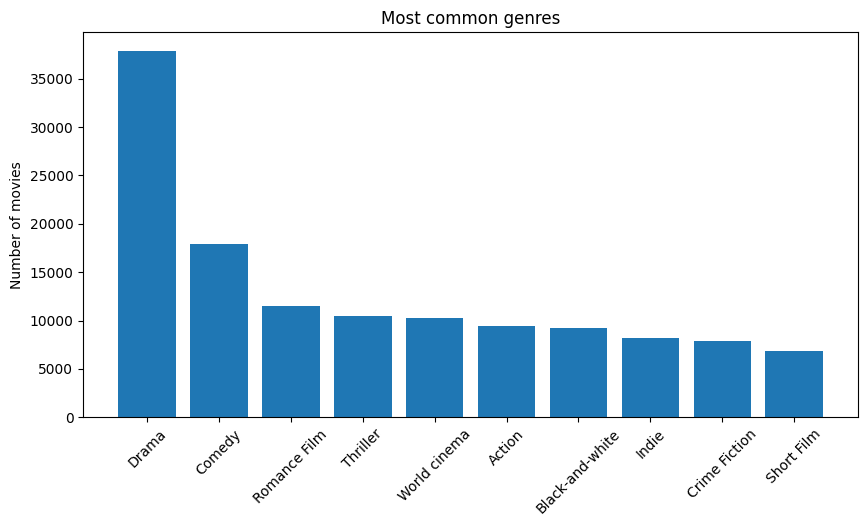

In [15]:
most_common_genres = df_genres_countries_exploded['genres'].value_counts().head(10)

plt.figure(figsize=(10,5))
plt.bar(most_common_genres.index, most_common_genres.values)
plt.title('Most common genres')
plt.ylabel('Number of movies')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Convert release date to year
df_genres_countries_exploded['year'] = pd.to_datetime(df_genres_countries_exploded['release_date']).dt.year

In [ ]:
# Timeline of apparition of genres
first_year_genre = df_genres_countries_exploded.groupby('genres')['release_date'].min().reset_index()
first_year_genre = first_year_genre.merge(df_genres_countries_exploded[['genres','countries','release_date']], on=['genres','release_date'], how='left')

# Plot a 2D graph with x=year, y=country, color=genre
fig = px.scatter(first_year_genre, x='release_date', y='countries', color='genres')
fig.update_layout(
    title='Timeline of apparition of genres',
    yaxis=dict(
        title='Countries',
        categoryorder='total ascending',  
        tickmode='array',
        tickvals=first_year_genre['countries'].unique(),
        automargin=True
    )
)
fig.show()

In [59]:
# Count the number of unique genres per country
genre_count_by_country = (
    first_year_genre.groupby('countries')['genres']
    .nunique()
    .reset_index()
    .rename(columns={'genres': 'genre_count'})
)

# Histogram of number of genres (y axis) per country (x axis)
fig = px.histogram(genre_count_by_country, x='countries', y='genre_count')
fig.update_layout(
    title='Number of genres first apparition per country',
    xaxis=dict(
        title='Countries',
        categoryorder='total descending',  
        tickmode='array',
        tickvals=genre_count_by_country['countries'].unique(),
        automargin=True
    ),
    yaxis=dict(
        title='Number of genres'
    )
)
fig.show()


In the previous scatterplot, we observe that the United States, France, Germany and the United Kingdom are the countries where most of the cinematographic genres appeared.

In [12]:
df1 = df_genres_countries_exploded.groupby(['region','year','genres']).size().reset_index(name='count')
df2 = df_genres_countries_exploded.groupby(['countries','year','genres']).size().reset_index(name='count')

# Save data
df1.to_csv('../../data/cultureData/df1.csv', index=False)
df2.to_csv('../../data/cultureData/df2.csv', index=False)

### 1. Analysis per world region

In [3]:
df = pd.read_csv('../../data/cultureData/df1.csv')
df.head(2)

,region,year,genres,count
0,Africa,1916,Drama,1
1,Africa,1916,Historical fiction,1


In [4]:
# Create the app
app1 = Dash(__name__)

app1.layout = html.Div([
    html.H1("Genre Evolution Over Time by Region"),
    html.Label("Select Regions:"),
    dcc.Dropdown(
        id='regions-multi-dropdown',
        options=[{'label': region, 'value': region} for region in df['region'].unique()],
        value=[df['region'].unique()[0]],
        multi=True
    ),
    html.Label("Select Genres:"),
    dcc.Dropdown(
        id='genres-multi-dropdown',
        options=[{'label': genre, 'value': genre} for genre in df['genres'].unique()],
        value=[df['genres'].unique()[0]],
        multi=True
    ),
    html.Div(id='multi-trends-container')  # Container for the charts
])

# Callback to update the charts
@app1.callback(
    Output('multi-trends-container', 'children'),
    [Input('regions-multi-dropdown', 'value'),
     Input('genres-multi-dropdown', 'value')]
)
def update_multi_trends(selected_regions, selected_genres):
    # Filter data
    filtered_df = df[(df['region'].isin(selected_regions)) & (df['genres'].isin(selected_genres))]
    trends = filtered_df.groupby(['year', 'genres', 'region'])['count'].sum().reset_index()
    
    # Generate charts for each genre
    graphs = []
    for genre in selected_genres:
        genre_data = trends[trends['genres'] == genre]
        fig = px.line(
            genre_data, 
            x='year', 
            y='count', 
            color='region',
            title=f"Trends for Genre: {genre}",
            labels={'count': 'Number of Films', 'year': 'Year'}
        )
        graphs.append(dcc.Graph(figure=fig))
    
    # Organize the charts: 2 per row
    rows = []
    for i in range(0, len(graphs), 2):
        row = html.Div(graphs[i:i + 2], style={'display': 'flex', 'justify-content': 'space-between'})
        rows.append(row)
    
    return rows

app1.run(port=8050)

As we can see in the previous graphs, some regions of the world develop new genres of films that are then taken up by other regions of the world. For example, in the Drama or Comedy category, the United States are the precursors and the other regions of the world follow the trend. In order, Europe, Asia, then South America and Africa start to produce films of these genres.

These first elements illustrate a form of cultural propagation throughout the world, which thus reflects the premises of globalization.

In [5]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [6]:
# Initialize Dash app
app2 = Dash()

app2.layout = html.Div([
    dcc.Dropdown(
        id="region-selector",
        options=[{"label": c, "value": c} for c in df["region"].unique()],
        value=[df["region"].unique()[0]],  # Default to the first region
        multi=True  # Enable multi-selection
    ),
    dcc.Graph(id="genre-proportion")
])

@app2.callback(
    Output("genre-proportion", "figure"),
    [Input("region-selector", "value")]
)

def update_genre_proportion(selected_regions):
    # Create a subplot layout for multiple pie charts
    cols = len(selected_regions)  # Number of columns (based on selected regions)
    fig = make_subplots(
        rows=1, cols=cols,
        subplot_titles=selected_regions,
        specs=[[{"type": "domain"}] * cols]
    )
    
    # Add a pie chart for each selected region
    for idx, region in enumerate(selected_regions):
        region_data = df[df["region"] == region]
        top_genres = (
            region_data.groupby("genres")["count"]
            .sum()
            .nlargest(5)
            .reset_index()
        )
        fig.add_trace(
            go.Pie(
                labels=top_genres["genres"],
                values=top_genres["count"],
                name=region,
                legendgroup="genres"  # Group legends across all pie charts
            ),
            row=1, col=idx + 1
        )
    
    # Update layout for shared legend
    fig.update_layout(
        title_text="Top 5 Genres for Selected Regions",
        title_x=0.5,  # Center the title
        height=500,
        legend=dict(
            orientation="v",  # Vertical legend
            x=1.05,  # Move legend to the right
            y=0.5,
            yanchor="middle"
        )
    )
    
    return fig

app2.run_server(mode='inline')

### 2. Analysis per country

In [85]:
df2 = pd.read_csv('../../data/cultureData/df2.csv')
df2.head()

,countries,year,genres,count
0,Afghanistan,1975,Action/Adventure,1
1,Afghanistan,1975,Bollywood,1
2,Afghanistan,1975,Thriller,1
3,Afghanistan,1975,World cinema,1
4,Afghanistan,1992,Action/Adventure,1


In [72]:
df_tot_nb_movies_per_genre_per_country = df2.groupby(['countries','genres']).size().reset_index(name='count')
df_most_genre_per_country = df_tot_nb_movies_per_genre_per_country.groupby('countries').apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

# Plot the number of times a genre is the most common genre in a country
most_genres_count = df_most_genre_per_country['genres'].value_counts()
proportion_most_common_genre = most_genres_count / most_genres_count.sum()

fig = px.bar(
    x=proportion_most_common_genre.index,
    y=proportion_most_common_genre.values,
    labels={'x': 'Genres', 'y': 'Proportion'},
    title='Proportion of times a genre is the most common genre in a country'
)
fig.show()


C:\Users\arnau\AppData\Local\Temp\ipykernel_34516\2996306357.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [73]:
# Plot a world map with the most common genre per country
fig = px.choropleth(df_most_genre_per_country, 
                    locations='countries',
                    locationmode='country names',
                    color='genres',
                    title='Most common genre per country',
                    hover_name='genres',
                    projection='natural earth')
fig.show()

If we consider the overall production of movies since the beginning of cinema's industry, we can see that almost the Drama is the most produced genre in each country.

In [86]:
df_most_genre_per_country_over_time = df2.groupby(['countries','year']).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

C:\Users\arnau\AppData\Local\Temp\ipykernel_34516\3535230502.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [95]:
# Générer les marques pour le slider (par exemple, tous les 10 ans)
slider_marks = {
    year: str(year) for year in range(
        df_most_genre_per_country_over_time['year'].min(),
        df_most_genre_per_country_over_time['year'].max() + 1,
        10  # Intervalle des années à afficher dans la légende
    )
}

# Initialiser l'application Dash
app3 = dash.Dash(__name__)

# Layout de l'application
app3.layout = html.Div([
    dcc.Graph(id='choropleth-map'),
    dcc.Slider(
        id='year-slider',
        min=df_most_genre_per_country_over_time['year'].min(),
        max=df_most_genre_per_country_over_time['year'].max(),
        value=df_most_genre_per_country_over_time['year'].min(),
        marks=slider_marks,
        step=1
    ),
    dcc.Interval(
        id='interval-component',
        interval=1000,  # Intervalle en millisecondes (ici 1 seconde)
        n_intervals=0
    )
])

# Callback pour mettre à jour la carte
@app3.callback(
    Output('choropleth-map', 'figure'),
    [Input('year-slider', 'value')]
)
def update_map(selected_year):
    filtered_df = df_most_genre_per_country_over_time[df_most_genre_per_country_over_time['year'] == selected_year]
    fig = px.choropleth(filtered_df,
                        locations='countries',
                        locationmode='country names',
                        color='genres',
                        title=f'Most common genre per country in {selected_year}',
                        hover_name='genres',
                        projection='natural earth')
    return fig

# Callback pour lire automatiquement l'année sur le slider
@app3.callback(
    Output('year-slider', 'value'),
    [Input('year-slider', 'value'),
     Input('interval-component', 'n_intervals')]
)
def auto_slide(current_value, n_intervals):
    # Incrémenter l'année à chaque intervalle
    next_year = current_value + 1
    if next_year > df_most_genre_per_country_over_time['year'].max():
        next_year = df_most_genre_per_country_over_time['year'].min()  # Revenir à la première année
    return next_year

# Exécuter l'application
if __name__ == '__main__':
    app3.run_server(debug=True)